In [77]:
# Import Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

In [78]:
# Import datasets
test_data = pd.read_csv('Medical_attn_preds.csv')
train_data = pd.read_csv('historical_marathon_dataset.csv')

event_vars = pd.read_csv('2025_event_vars.csv')
summary_vars = pd.read_csv('event_summary.csv')

In [79]:
# Add event conditions to other datasets
# train_data
train_data = train_data.merge(summary_vars, on='year', how='left')

# test_data
for col in event_vars.columns:
    test_data[col] = event_vars.iloc[0][col]

In [80]:
# Change male and female into 0 and 1
train_data['gender'] = train_data['gender'].map({'Male': 1, 'Female': 0})

# Remove columns which are unnecessary
test_data = test_data.drop(columns=['country', 'shoe_brand', 'injured_prev_mth', 'injured_prev_qtr', 'injured_prev_hy', 'gel_support', 'newsletter_registration'])
train_data = train_data.drop(columns=['country', 'shoe_brand', 'injured_prev_mth', 'injured_prev_qtr', 'injured_prev_hy', 'gel_support', 'newsletter_registration'])

# Keep only people who will be injured
train_data = train_data[train_data['medical_km_bin'].notna()].copy()
test_data = test_data[test_data['medical_attn_pred'] != 0]

# Add the medical_km to the training data
train_data['medical_km'] = train_data['medical_km_bin']

In [81]:
# Setup the feature columns
base_features = ['age', 'gender', 'height', 'weight', 'weekly_km', 'marathons_xp', 'personal_best']

event_features = [
    'temp_10am', 'humidity', 'rainfall', 'elevation_gain',
    'hydration_stations', 'stretching_station',
    'music_at_start', 'toilet_stations', 'crowding_density',
]

predictor_cols = (
    base_features + 
    event_features
)

In [89]:
# Prepare features and target
X = train_data[predictor_cols]
y = train_data['medical_km']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
#model = XGBRegressor(
#    n_estimators=2000, 
#    max_depth=10, 
#    learning_rate=0.05,
#    subsample=0.9,
#    colsample_bytree=0.8,
#    random_state=42
#)

#param_grid = {
#    'n_estimators': [100, 200, 300, 500],
#    'max_depth': [3, 4, 5, 6],
#    'learning_rate': [0.01, 0.05, 0.1, 0.2],
#   'subsample': [0.8, 0.9],
#   'colsample_bytree': [0.8, 0.9, 1.0],
#    'reg_alpha': [0, 0.1, 0.5, 1],
#    'reg_lambda': [0.1, 0.5, 1, 2]
#}

#model = XGBRegressor(
#    random_state=42, 
#    n_jobs=-1,
#    verbosity=0
#)

#grid_search = GridSearchCV(
#    estimator=model,
#    param_grid=param_grid,  # Start with quick grid, then use full param_grid
#    scoring='neg_mean_absolute_error',  # Good for distance prediction
#    cv=3,  # 5-fold cross-validation
#    n_jobs=-1,  # Parallel processing
#    verbose=1,  # Show progress
#    return_train_score=True
#)

#grid_search.fit(X_train, y_train)

# Get best parameters and score
#print("\n" + "="*50)
#print("GRID SEARCH RESULTS")
#print("="*50)
#print(f"Best parameters: {grid_search.best_params_}")
#print(f"Best cross-validation score (MAE): {-grid_search.best_score_:.4f}")

# Train final model with best parameters
#best_model = grid_search.best_estimator_
#best_model.fit(X_train, y_train)

# Make predictions
#y_pred_train = best_model.predict(X_train)
#y_pred_test = best_model.predict(X_test)

#model.fit(X_train, y_train)

# Predict on validation set
#val_preds = model.predict(X_val)

# Evaluate
#mse = mean_squared_error(y_val, val_preds)
#mae = mean_absolute_error(y_val, val_preds)

#print(f"📉 MSE: {mse:.2f} km²")
#print(f"📏 MAE: {mae:.2f} km (average error)")

==================================================
GRID SEARCH RESULTS
==================================================
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.8}
Best cross-validation score (MAE): 7.1061

In [100]:
# Train the model
model = XGBRegressor(
    n_estimators=2000, 
    max_depth=10, 
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42, 
    objective='reg:squarederror'
)

model.fit(X_train, y_train)

# Predict on validation set
val_preds = model.predict(X_val)

# Evaluate
mse = mean_squared_error(y_val, val_preds)
mae = mean_absolute_error(y_val, val_preds)

print(f"📉 MSE: {mse:.2f} km²")
print(f"📏 MAE: {mae:.2f} km (average error)")

📉 MSE: 90.31 km²
📏 MAE: 7.85 km (average error)


In [105]:
# Train on full data and predict on test_data
X_test = test_data[predictor_cols]
final_preds = model.fit(X, y).predict(X_test)

# Add medical_km to test data
test_data['medical_km'] = final_preds

# Output results
evaluation_results = {
    "MSE Matrix": mse,
    "MAE Report": mae,
    "Test Predictions (Sample)": final_preds[:10]
}

evaluation_results

{'MSE Matrix': 90.31191176292162,
 'MAE Report': 7.848673162601175,
 'Test Predictions (Sample)': array([27.54799 , 25.25686 , 24.882454, 25.620216, 26.25836 , 19.313246,
        29.096401, 23.258148, 26.003225, 21.843235], dtype=float32)}

In [110]:
test_data.to_csv('injury_loc.csv', index=False)
print('Downloaded injury_loc.csv')

Downloaded injury_loc.csv


OTHER INFO / TESTS


RESIDUALS ANALYSIS:
Mean residual: 0.3721
Std residual: 9.4960
Skewness: -0.2559
Kurtosis: -0.5608


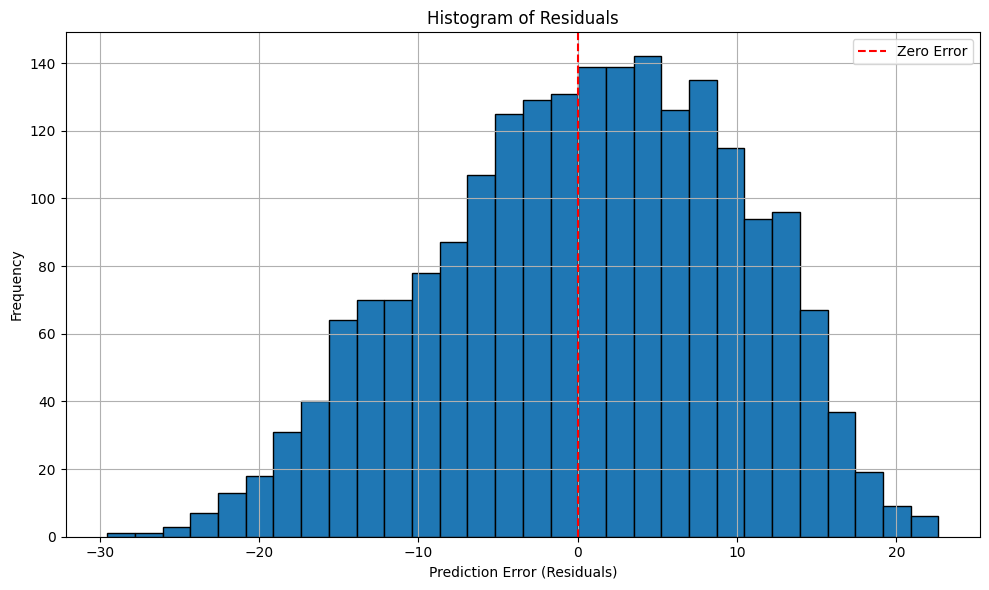

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these already:
# y_true = actual values
# y_pred = predicted values

residuals = y_val - val_preds

print(f"\nRESIDUALS ANALYSIS:")
print(f"Mean residual: {np.mean(residuals):.4f}")
print(f"Std residual: {np.std(residuals):.4f}")
print(f"Skewness: {pd.Series(residuals).skew():.4f}")
print(f"Kurtosis: {pd.Series(residuals).kurtosis():.4f}")

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Prediction Error (Residuals)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
